In [1]:
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import json
from flatten_json import flatten


In [2]:
import mpld3
# mpld3.enable_notebook()
%matplotlib notebook
# %matplotlib inline
import matplotlib.pyplot as plt
# plt.rcParams["figure.figsize"] = (15,5)

# Loading Files

In [3]:
fan1 = pd.read_csv('blender_data/D01_06-07-19_11-02-19.csv')
fan2 = pd.read_csv('blender_data/D02_06-07-19_11-02-19.csv')
fan3 = pd.read_csv('blender_data/D03_06-07-19_11-02-19.csv')
fan4 = pd.read_csv('blender_data/D04_06-07-19_11-02-19.csv')
fan5 = pd.read_csv('blender_data/D05_06-07-19_11-02-19.csv')
fan6 = pd.read_csv('blender_data/D06_06-07-19_11-02-19.csv')
fan7 = pd.read_csv('blender_data/D07_06-07-19_11-02-19.csv')
fan8 = pd.read_csv('blender_data/D08_06-07-19_11-02-19.csv')
fan9 = pd.read_csv('blender_data/D09_06-07-19_11-02-19.csv')
fan10 = pd.read_csv('blender_data/D10_06-07-19_11-02-19.csv')
fan11 = pd.read_csv('blender_data/D11_06-07-19_11-02-19.csv')
fan12 = pd.read_csv('blender_data/D12_06-07-19_11-02-19.csv')
fan13 = pd.read_csv('blender_data/D13_06-07-19_11-02-19.csv')
fan14 = pd.read_csv('blender_data/D14_06-07-19_11-02-19.csv')
fan15 = pd.read_csv('blender_data/D15_06-07-19_11-02-19.csv')
fan_list = [fan1, fan2, fan3, fan4, fan5, fan6, fan7, fan8, fan9, fan10, fan11, fan12, fan13, fan14, fan15]

# Processing

In [4]:
# This function prepare the dataframe for analysis and resample data at 15min interval to align with utility charge
def process_data(fan, month):
    if not isinstance(fan.index, pd.DatetimeIndex): # used to prevent issues on consecutive running over same data
        fan['time'] = pd.to_datetime(fan['time'], utc=True)
        fan.set_index('time', inplace=True)
        fan.index = fan.index.tz_convert('America/Los_Angeles')
        fan = fan.sort_index()
    data = fan.loc[(fan.index.month==month)]
    
    df = pd.DataFrame()    
    df['TotalPower']=data['TotalPower'].resample('15min').mean().bfill()
    df['GridPower']=data['GridPower'].resample('15min').mean().bfill()
    df['PvPower']=data['PvPower'].resample('15min').mean().bfill()
    
    return df

# Function to aggregate all 15 fans data into one df with the sum of all individual fans
def fan_aggregation(fan_list, month):
    df_list = []
    for f in fan_list:
        df_list.append(process_data(f,month))

    # Total Power
    power_total = 0
    for i in df_list:
        power_total = power_total+i['TotalPower']
    power_total.plot()

    # Total Grid Power
    grid_total = 0
    for i in df_list:
        grid_total = grid_total+i['GridPower']
    grid_total.plot()

    # Total PV Power
    pv_total = 0
    for i in df_list:
        pv_total = pv_total+i['PvPower']
    pv_total.plot()

    # Rebuilding new DF
    month_df = pd.DataFrame()
    month_df['Total_Power'] = power_total
    month_df['Grid_Power'] = grid_total
    month_df['PV_Power'] = pv_total
    month_df['day_of_week'] = power_total.index.dayofweek

    # Removing offset from measurements: Simple way to remove differences when PV is generating and grid is off but fans are not running.
    # 1000W was picked based on eye inspection - not optimal but good enough for now
    month_df.loc[month_df['Total_Power'] < 1000, 'Total_Power'] = 0
    month_df.loc[month_df['Grid_Power'] < 1000, 'Grid_Power'] = 0
    month_df.loc[month_df['PV_Power'] < 1000, 'PV_Power'] = 0
    
    return month_df

# Cost Function

In [5]:
def cost_analysis(df):
    # Cost values
    energy_pk_summer = 0.31752 # $/kWh
    energy_opk_summer = 0.16888 # $/kWh
    demand_max_summer = 10.77 # $/kW -> Maximum demand during billing cycle
    demand_max_pk_summer = 5.79 # $/kW -> Maximum demand during pek hours for billing cycle
    pk_hours_start = 12
    pk_hours_end = 18
    
    # Peak/Off-Peak hours
    pk_hours_mask = (df.index.hour >= pk_hours_start) & (df.index.hour <= pk_hours_end)
    opk_hours_mask = ~pk_hours_mask
    
    # Peak during month for max_summer:
    # With Blender
    pk_summer_blender = df['Grid_Power'].max()
    # Without Blender
    pk_summer = df['Total_Power'].max()
    
    # Peak during Peak hours for demand_max_pk_summer
    # With Blender
    grid = df['Grid_Power']
    pkh_summer_blender = grid[pk_hours_mask].max()
    # Without Blender
    grid = df['Total_Power']
    pkh_summer = grid[pk_hours_mask].max()
    
    # Getting weekdays
    wdays_mask = (df['day_of_week'] >= 0) & (df['day_of_week'] <= 4)
    
    # Getting weekends
    wends_mask = (df['day_of_week'] > 4)
    
    # energy calculation without blender:
    # weedays
    wdays_df = df[wdays_mask]
    pk_hours_mask = (wdays_df.index.hour >= pk_hours_start) & (wdays_df.index.hour <= pk_hours_end)
    opk_hours_mask = ~pk_hours_mask
    wdays_pk_hr = wdays_df[pk_hours_mask]
    wdays_opk_hr = wdays_df[opk_hours_mask]
    wdays_energy = ((wdays_pk_hr['Total_Power']*energy_pk_summer).sum() + (wdays_opk_hr['Total_Power']*energy_opk_summer).sum())/4/1000 # /4 -> 15min interval, /1000 -> converting to kW
    # weekends
    wends_df = df[wends_mask]
    wends_energy = ((wends_df['Total_Power']*energy_opk_summer).sum())/4/1000 # /4 -> 15min interval, /1000 -> converting to kW
    # Demand Charges without blender
    dem_pkh = pkh_summer*demand_max_pk_summer/1000
    dem_pk = pk_summer*demand_max_summer/1000
    total_cost = wdays_energy+wends_energy+dem_pkh+dem_pk
    print('Energy Component: ', wdays_energy+wends_energy)
    print('Demand Component: ', dem_pkh+dem_pk)
    print('Total [$]: ', total_cost)
    
    
    
    # energy calculation with blender:
    # weedays
    wdays_energy_blender = ((wdays_pk_hr['Grid_Power']*energy_pk_summer).sum() + (wdays_opk_hr['Grid_Power']*energy_opk_summer).sum())/4/1000 # /4 -> 15min interval, /1000 -> converting to kW
    # weekends
    wends_energy_blender = ((wends_df['Grid_Power']*energy_opk_summer).sum())/4/1000 # /4 -> 15min interval, /1000 -> converting to kW
    # Demand Charges with blender
    dem_pkh_blender = pkh_summer_blender*demand_max_pk_summer/1000
    dem_pk_blender = pk_summer_blender*demand_max_summer/1000
    total_cost_blender = wdays_energy_blender+wends_energy_blender+dem_pkh_blender+dem_pk_blender
    print('Blender Energy Component: ', wdays_energy_blender+wends_energy_blender)
    print('Blender Demand Component: ', dem_pkh_blender+dem_pk_blender)
    print('Blender Total [$]: ', total_cost_blender)
    
    print('TOTAL SAVINGS WITH BLENDERS [%]: ', 100*(1-((wdays_energy_blender+wends_energy_blender+dem_pkh_blender+dem_pk_blender)/(wdays_energy+wends_energy+dem_pkh+dem_pk))))
    
    return [total_cost, total_cost_blender]
    

# Solar Contribution

In [6]:
def solar_contribution(df, month):
    daily_grid = df['Grid_Power'].resample('D').sum()/4/1000
    daily_pv = df['PV_Power'].resample('D').sum()/4/1000
    x_axis = range(1,len(daily_grid)+1)
    plt.bar(x_axis, daily_pv, color='orange',edgecolor='white', label='solar')
    plt.bar(x_axis, daily_grid, bottom=daily_pv, color='blue', edgecolor='white', label='grid')
    plt.xlabel('Day of the Month')
    plt.ylabel('Daily Energy [kWh]')
    plt.legend()
    plt.title(month)

    # Solar Contribution:
    solar_cont = 100*(daily_pv/(daily_pv+daily_grid))

    # x = np.linspace(0, N)
    # y = np.sin(x)
    axes2 = plt.twinx()
    axes2.plot(x_axis, solar_cont, color='r')
    axes2.set_ylim(0, 100)
    axes2.set_ylabel('Solar Contribution[%]')


# July Analysis

<IPython.core.display.Javascript object>


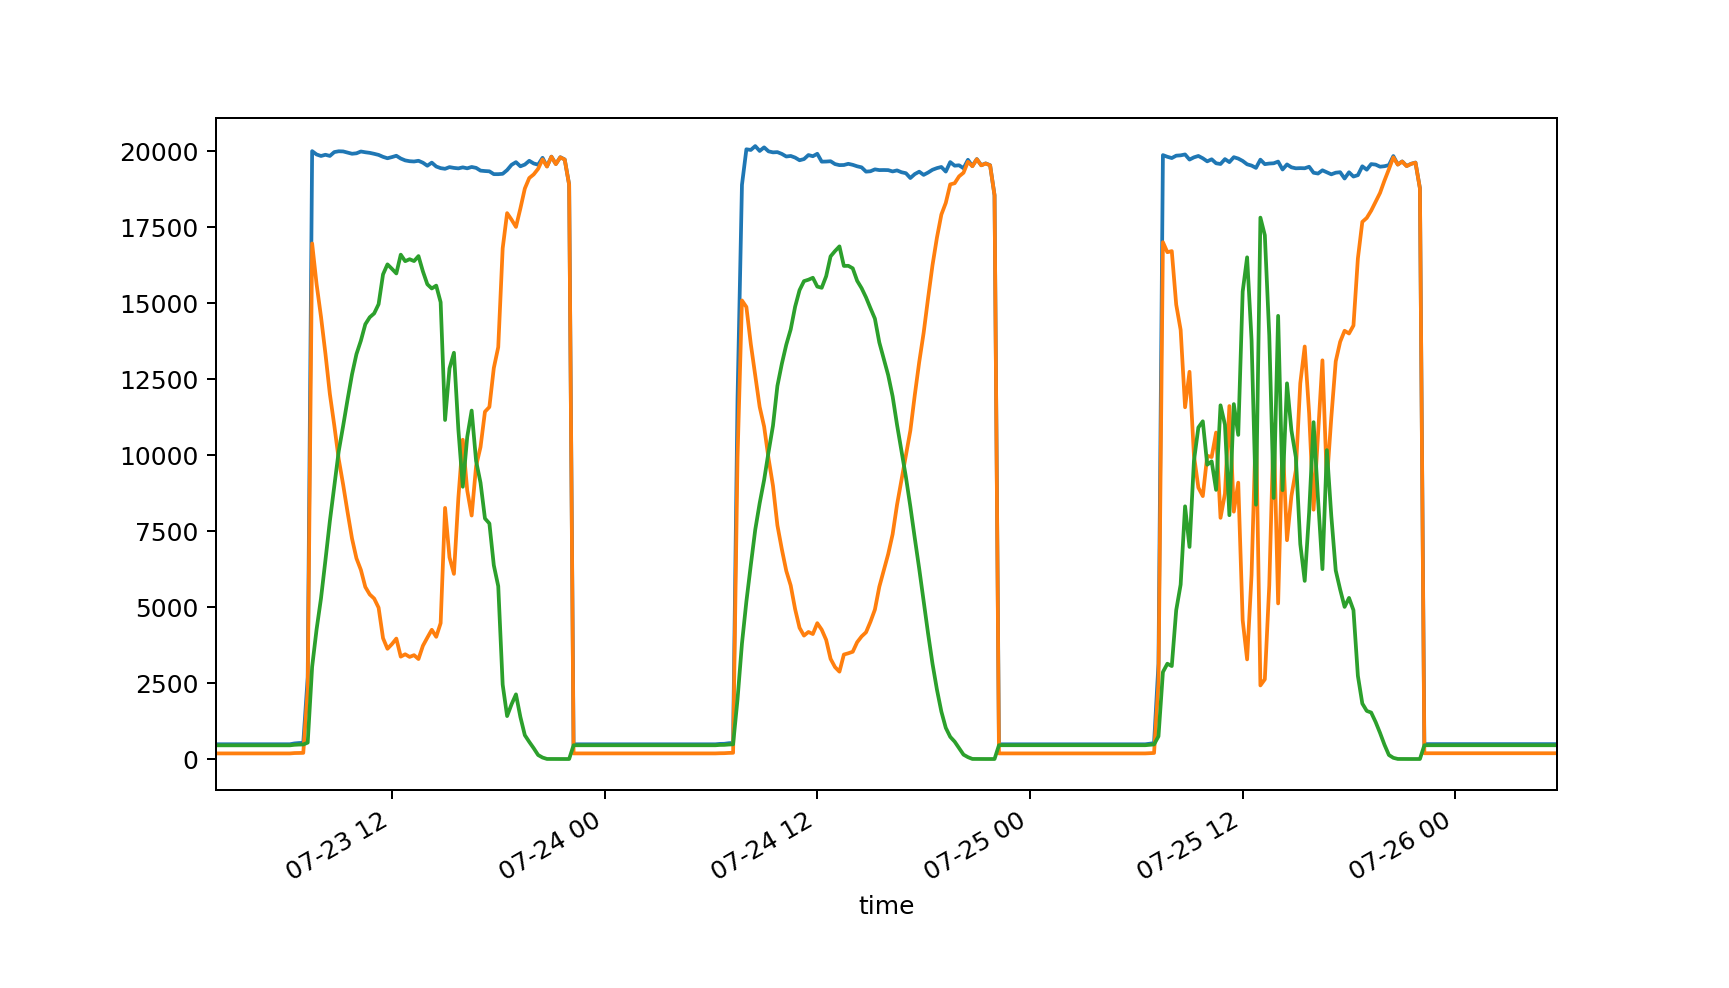

In [7]:
july = fan_aggregation(fan_list, 7)

<IPython.core.display.Javascript object>


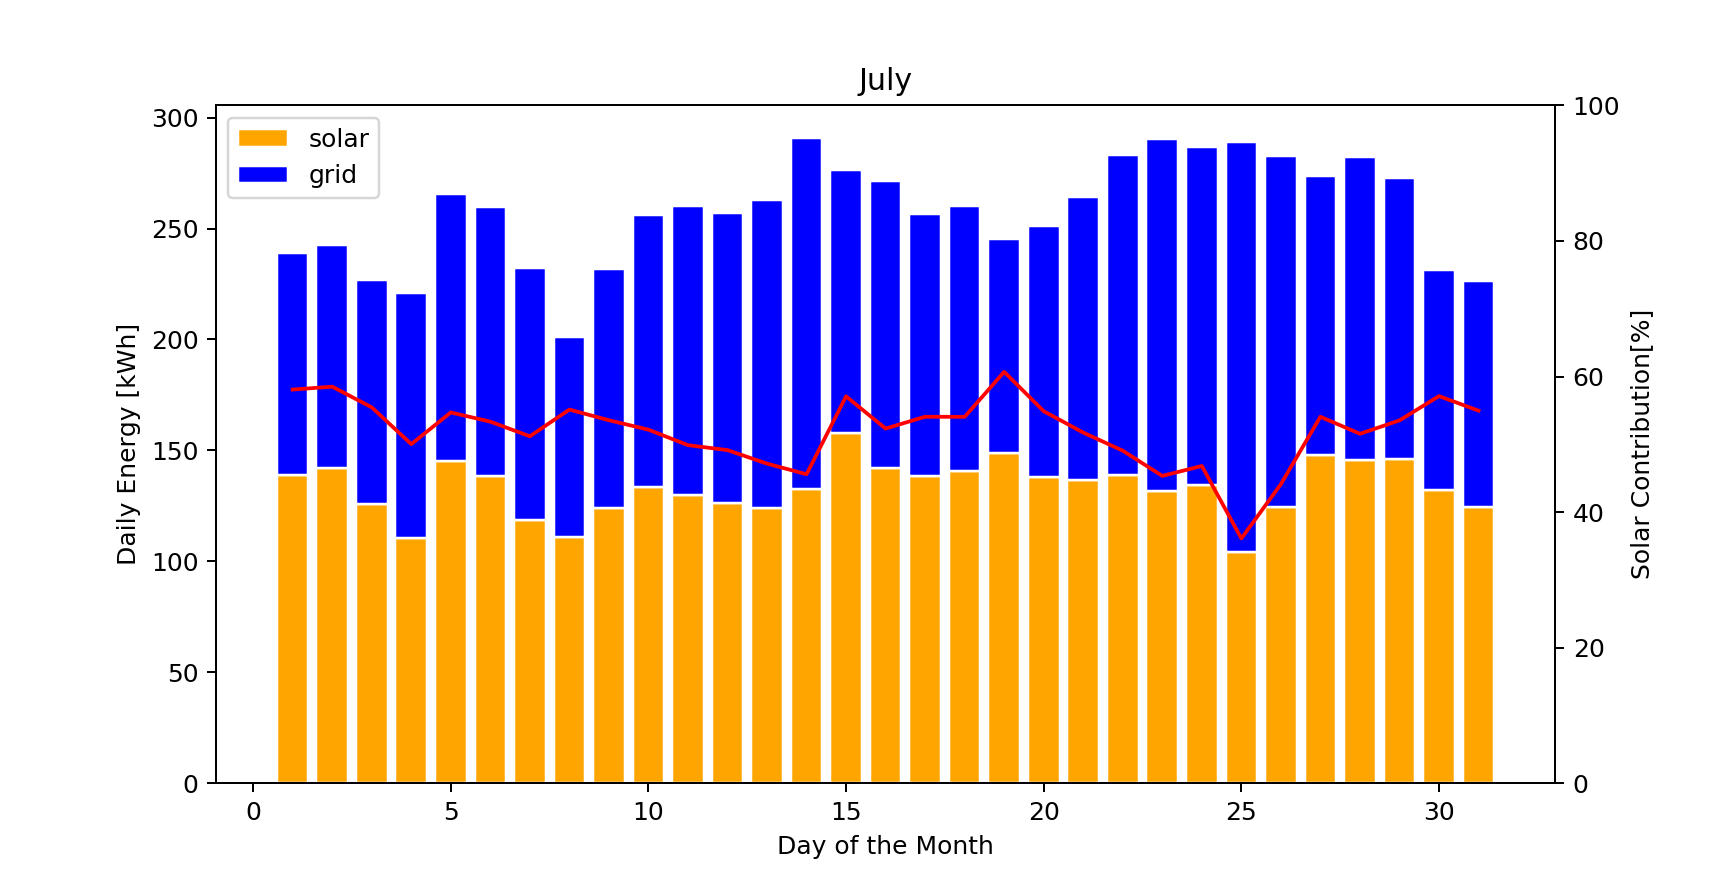

In [64]:
solar_contribution(july, 'July')

In [13]:
print('JULY COST')
july_cost = cost_analysis(july)
print()
print('Cost per barn: ', july_cost[0]*2)
print('Cost per barn with blender: ', july_cost[1]*2)
print()
print('Farm Cost: ', july_cost[0]*2*12)
print('Farm Cost with Blender: ', july_cost[1]*2*12)


JULY COST
Energy Component:  1817.5058240179692
Demand Component:  338.9666895868421
Total [$]:  2156.4725136048114
Blender Energy Component:  813.7493117293105
Blender Demand Component:  322.8763875031579
Blender Total [$]:  1136.6256992324684
TOTAL SAVINGS WITH BLENDERS [%]:  47.292363243134616

Cost per barn:  4312.945027209623
Cost per barn with blender:  2273.2513984649368

Farm Cost:  51755.34032651548
Farm Cost with Blender:  27279.01678157924


# August Analysis

<IPython.core.display.Javascript object>


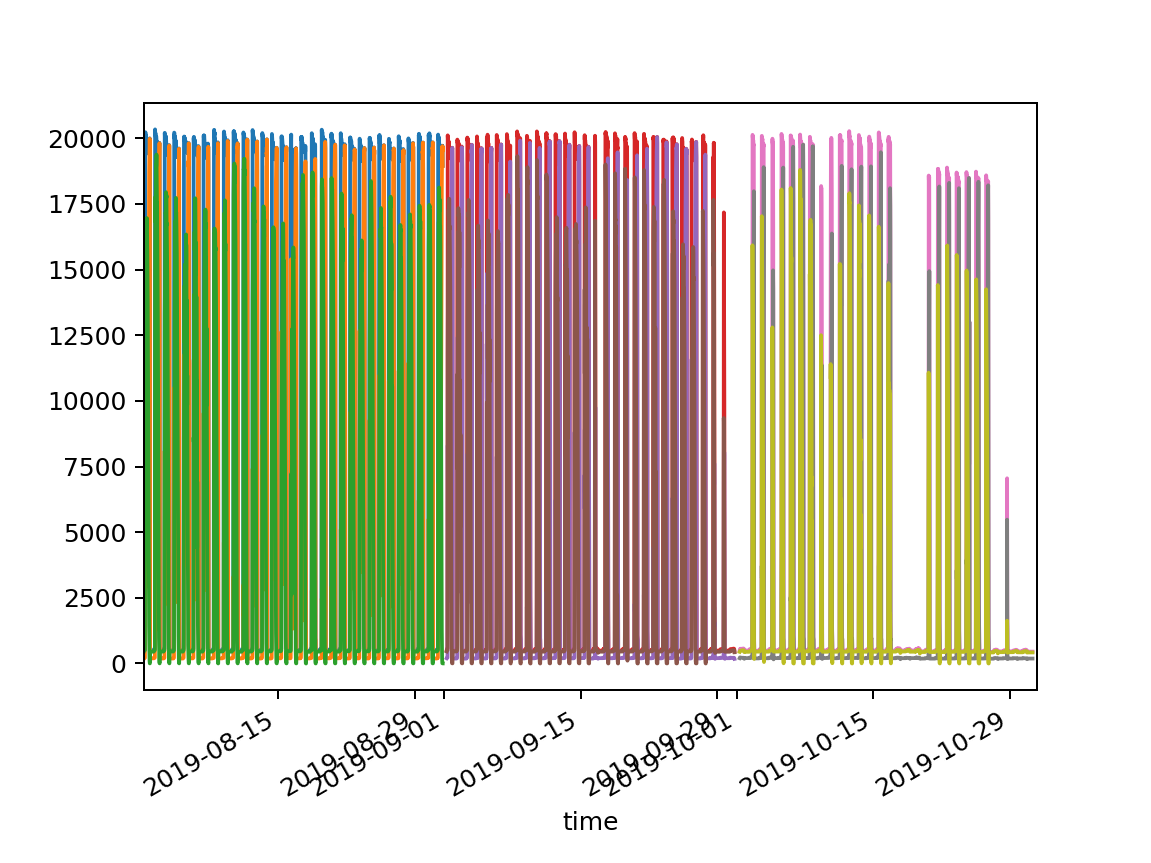

In [7]:
august = fan_aggregation(fan_list, 8)

<IPython.core.display.Javascript object>


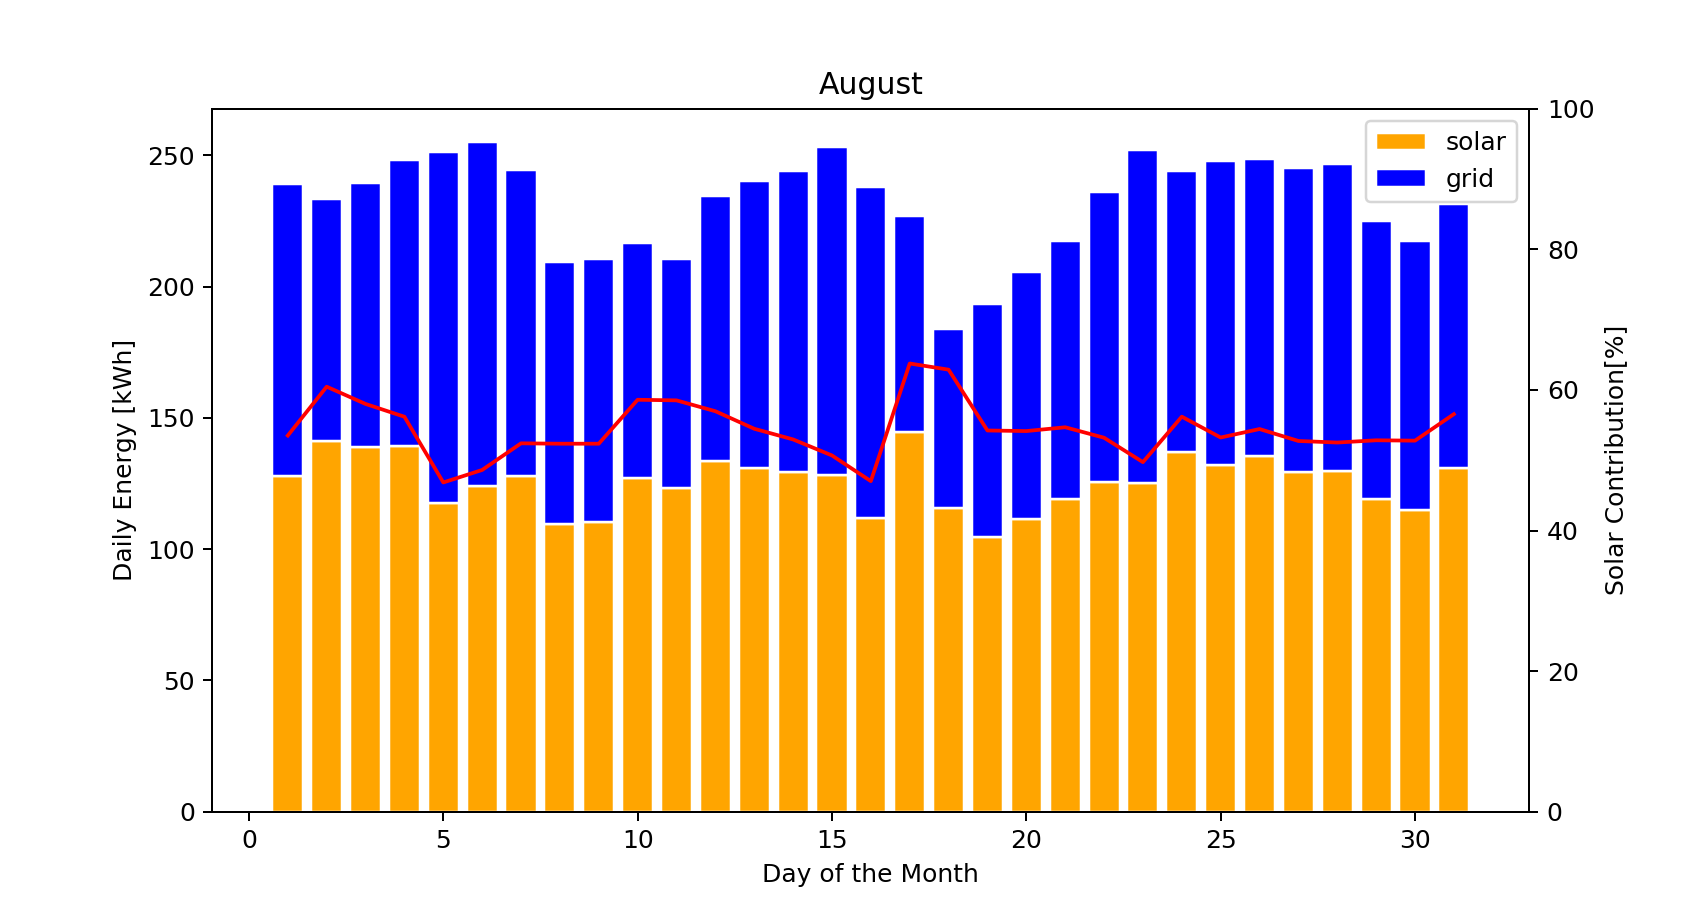

In [40]:
solar_contribution(august, 'August')

In [41]:
print('AUGUST COST')
august_cost = cost_analysis(august)
print()
print('Cost per barn: ', august_cost[0]*2)
print('Cost per barn with blender: ', august_cost[1]*2)
print()
print('Farm Cost: ', august_cost[0]*2*12)
print('Farm Cost with Blender: ', august_cost[1]*2*12)

AUGUST COST
Energy Component:  1658.5723349732339
Demand Component:  336.414233985
Total [$]:  1994.9865689582339
Blender Energy Component:  725.3717674877
Blender Demand Component:  322.57126923000004
Blender Total [$]:  1047.9430367177001
TOTAL SAVINGS WITH BLENDERS [%]:  47.47117333903016

Cost per barn:  3989.9731379164677
Cost per barn with blender:  2095.8860734354002

Farm Cost:  47879.67765499761
Farm Cost with Blender:  25150.632881224803


# September Analysis

In [8]:
september = fan_aggregation(fan_list, 9)

<IPython.core.display.Javascript object>


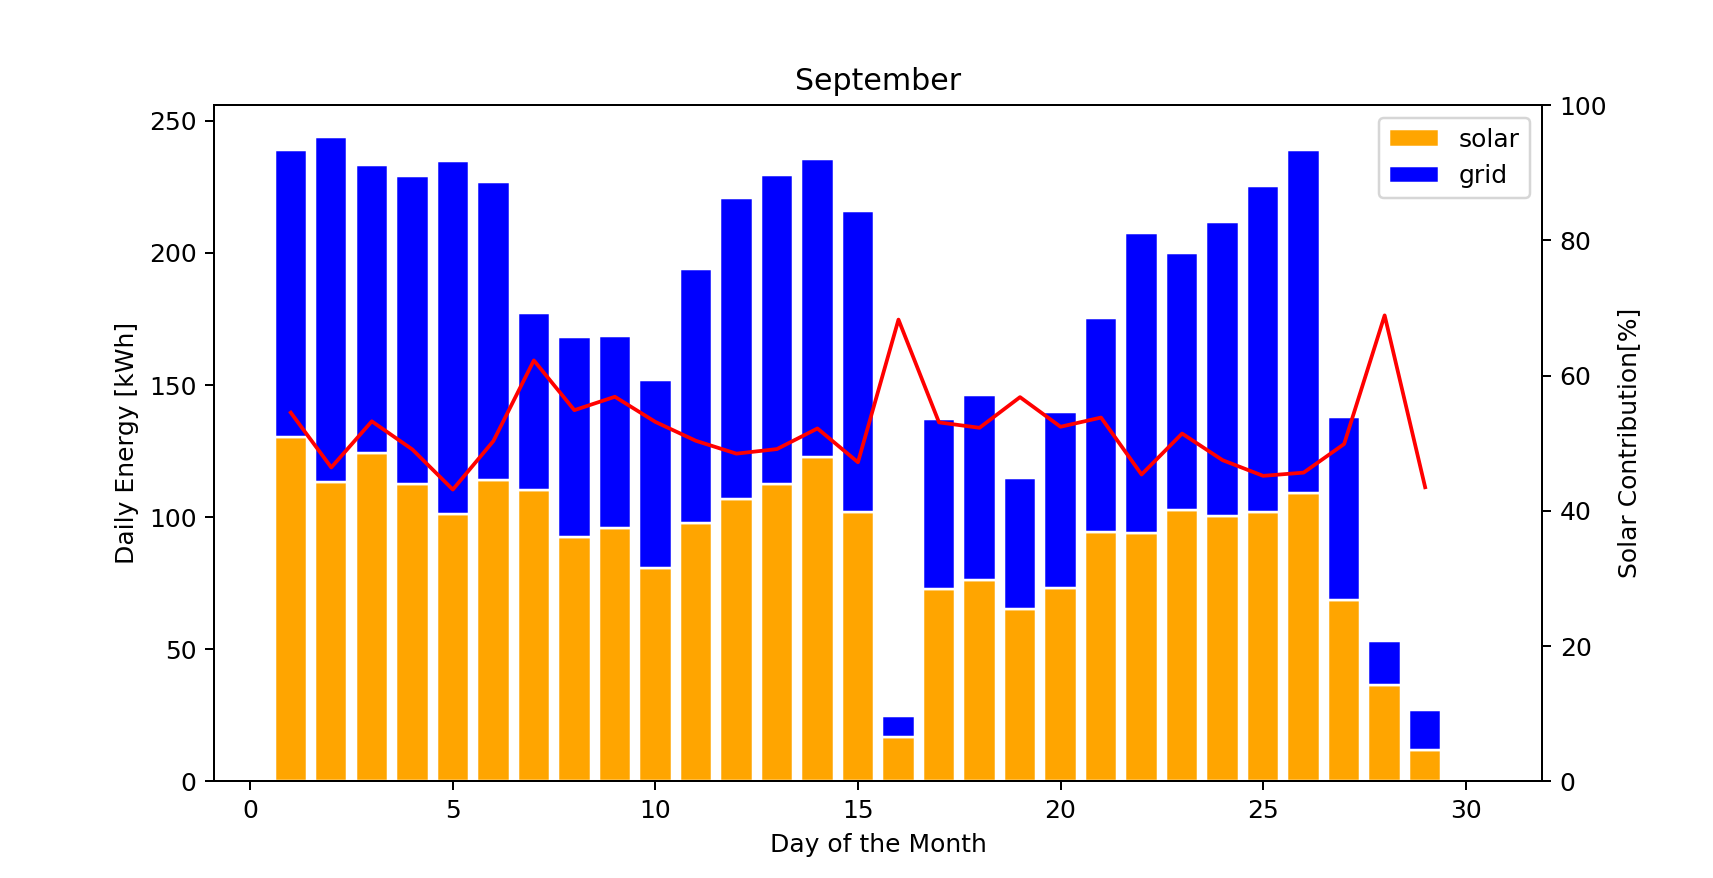

In [65]:
solar_contribution(september, 'September')

In [15]:
print('SEPTEMBER COST')
september_cost = cost_analysis(september)
print()
print('Cost per barn: ', september_cost[0]*2)
print('Cost per barn with blender: ', september_cost[1]*2)
print()
print('Farm Cost: ', september_cost[0]*2*12)
print('Farm Cost with Blender: ', september_cost[1]*2*12)

SEPTEMBER COST
Energy Component:  1254.9629962263914
Demand Component:  335.5524033536842
Total [$]:  1590.5153995800756
Blender Energy Component:  593.9714473108514
Blender Demand Component:  328.117926825
Blender Total [$]:  922.0893741358514
TOTAL SAVINGS WITH BLENDERS [%]:  42.02574999403971

Cost per barn:  3181.030799160151
Cost per barn with blender:  1844.1787482717027

Farm Cost:  38172.369589921815
Farm Cost with Blender:  22130.144979260433


# October Analysis

In [9]:
october = fan_aggregation(fan_list, 10)

<IPython.core.display.Javascript object>


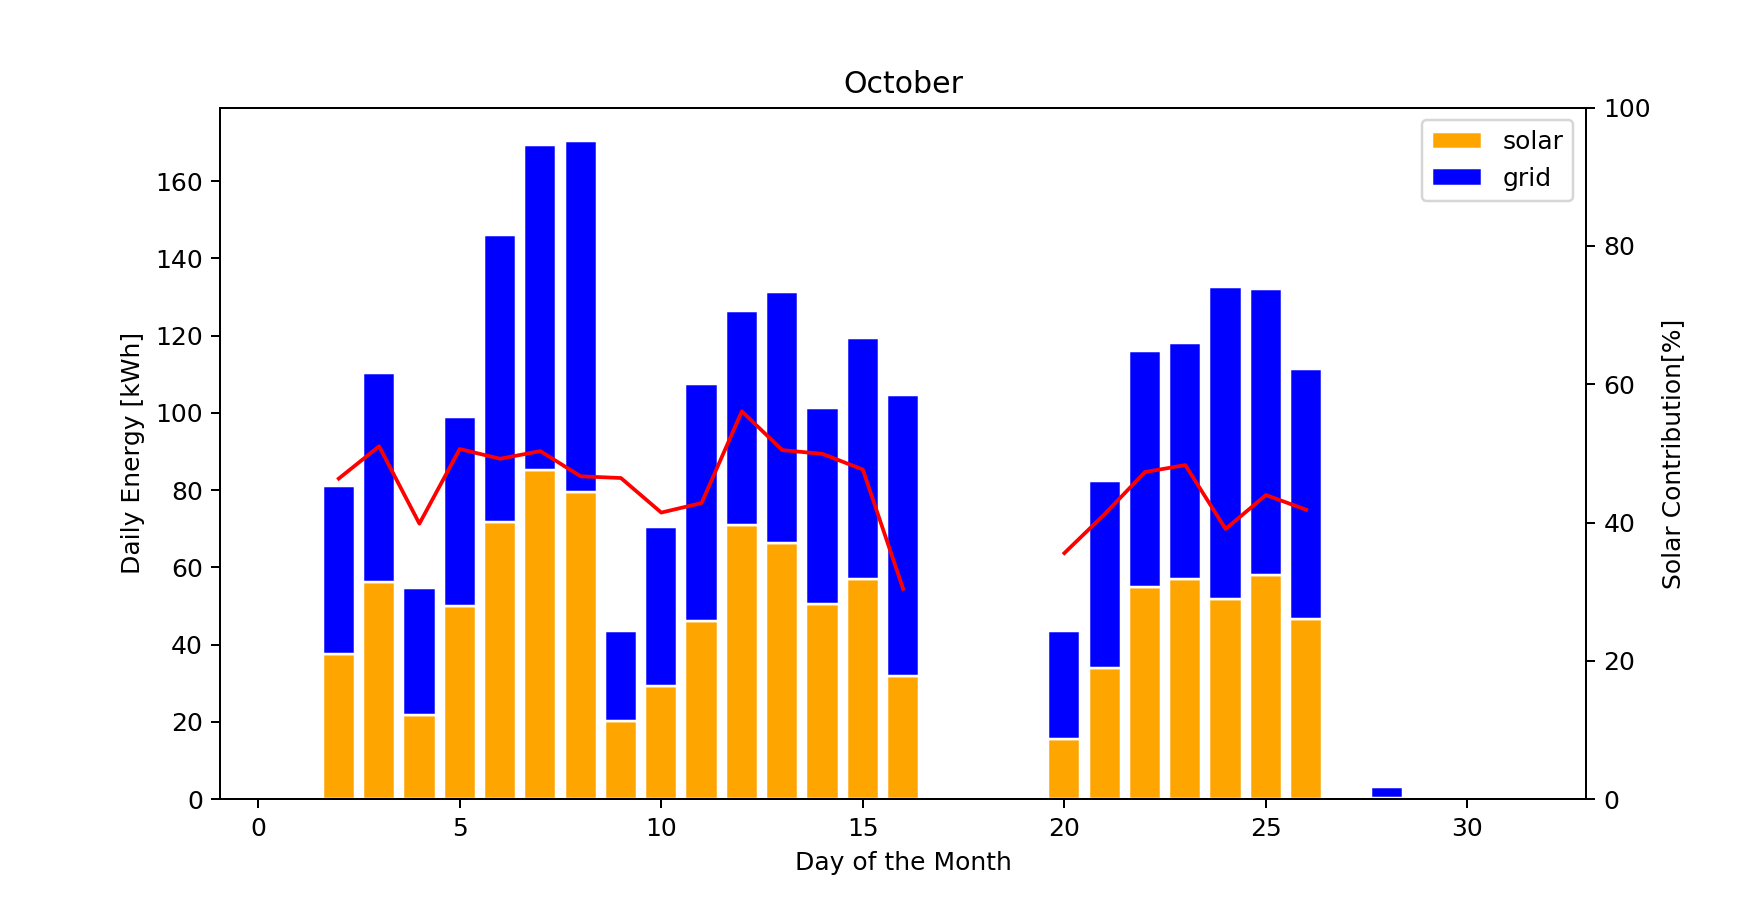

In [67]:
solar_contribution(october, 'October')

In [17]:
print('OCTOBER COST')
october_cost = cost_analysis(october)
print()
print('Cost per barn: ', october_cost[0]*2)
print('Cost per barn with blender: ', october_cost[1]*2)
print()
print('Farm Cost: ', october_cost[0]*2*12)
print('Farm Cost with Blender: ', october_cost[1]*2*12)

OCTOBER COST
Energy Component:  643.3801140526105
Demand Component:  335.71312794857147
Total [$]:  979.0932420011819
Blender Energy Component:  346.48058795209107
Blender Demand Component:  326.7841197478572
Blender Total [$]:  673.2647076999483
TOTAL SAVINGS WITH BLENDERS [%]:  31.235894721951762

Cost per barn:  1958.1864840023638
Cost per barn with blender:  1346.5294153998966

Farm Cost:  23498.237808028367
Farm Cost with Blender:  16158.35298479876


In [11]:
august

,Total_Power,Grid_Power,PV_Power,day_of_week
time,,,,
2019-08-01 06:30:00-07:00,0.000000,0.000000,0.0,3
2019-08-01 06:45:00-07:00,0.000000,0.000000,0.0,3
2019-08-01 07:00:00-07:00,0.000000,0.000000,0.0,3
2019-08-01 07:15:00-07:00,0.000000,0.000000,0.0,3
2019-08-01 07:30:00-07:00,0.000000,0.000000,0.0,3
...,...,...,...,...
2019-08-31 20:00:00-07:00,19692.261500,19685.453000,0.0,5
2019-08-31 20:15:00-07:00,19497.109500,19492.698000,0.0,5
2019-08-31 20:30:00-07:00,19704.108000,19699.737000,0.0,5


<IPython.core.display.Javascript object>


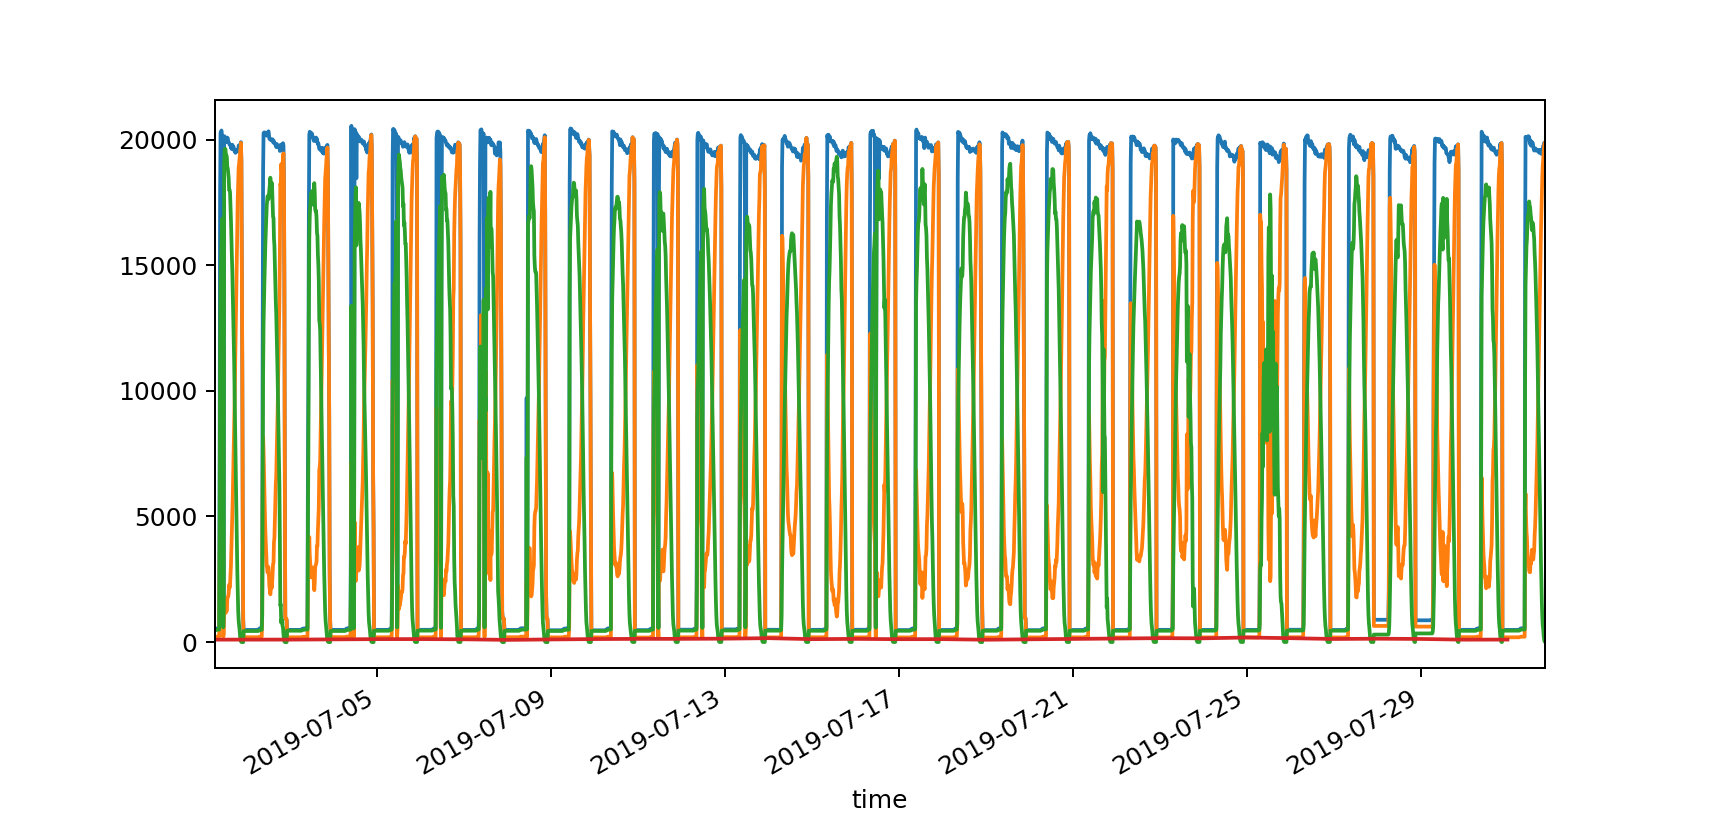

In [6]:
july = fan_aggregation(fan_list, 7)

In [7]:
july.head()

,Total_Power,Grid_Power,PV_Power,day_of_week
time,,,,
2019-07-01 06:15:00-07:00,0.0,0.0,0.0,0
2019-07-01 06:30:00-07:00,0.0,0.0,0.0,0
2019-07-01 06:45:00-07:00,0.0,0.0,0.0,0
2019-07-01 07:00:00-07:00,0.0,0.0,0.0,0
2019-07-01 07:15:00-07:00,0.0,0.0,0.0,0


In [53]:
daily_grid = august['Grid_Power'].resample('D').sum()/4/1000
daily_pv = august['PV_Power'].resample('D').sum()/4/1000


In [60]:
len(daily_grid)

31

<IPython.core.display.Javascript object>


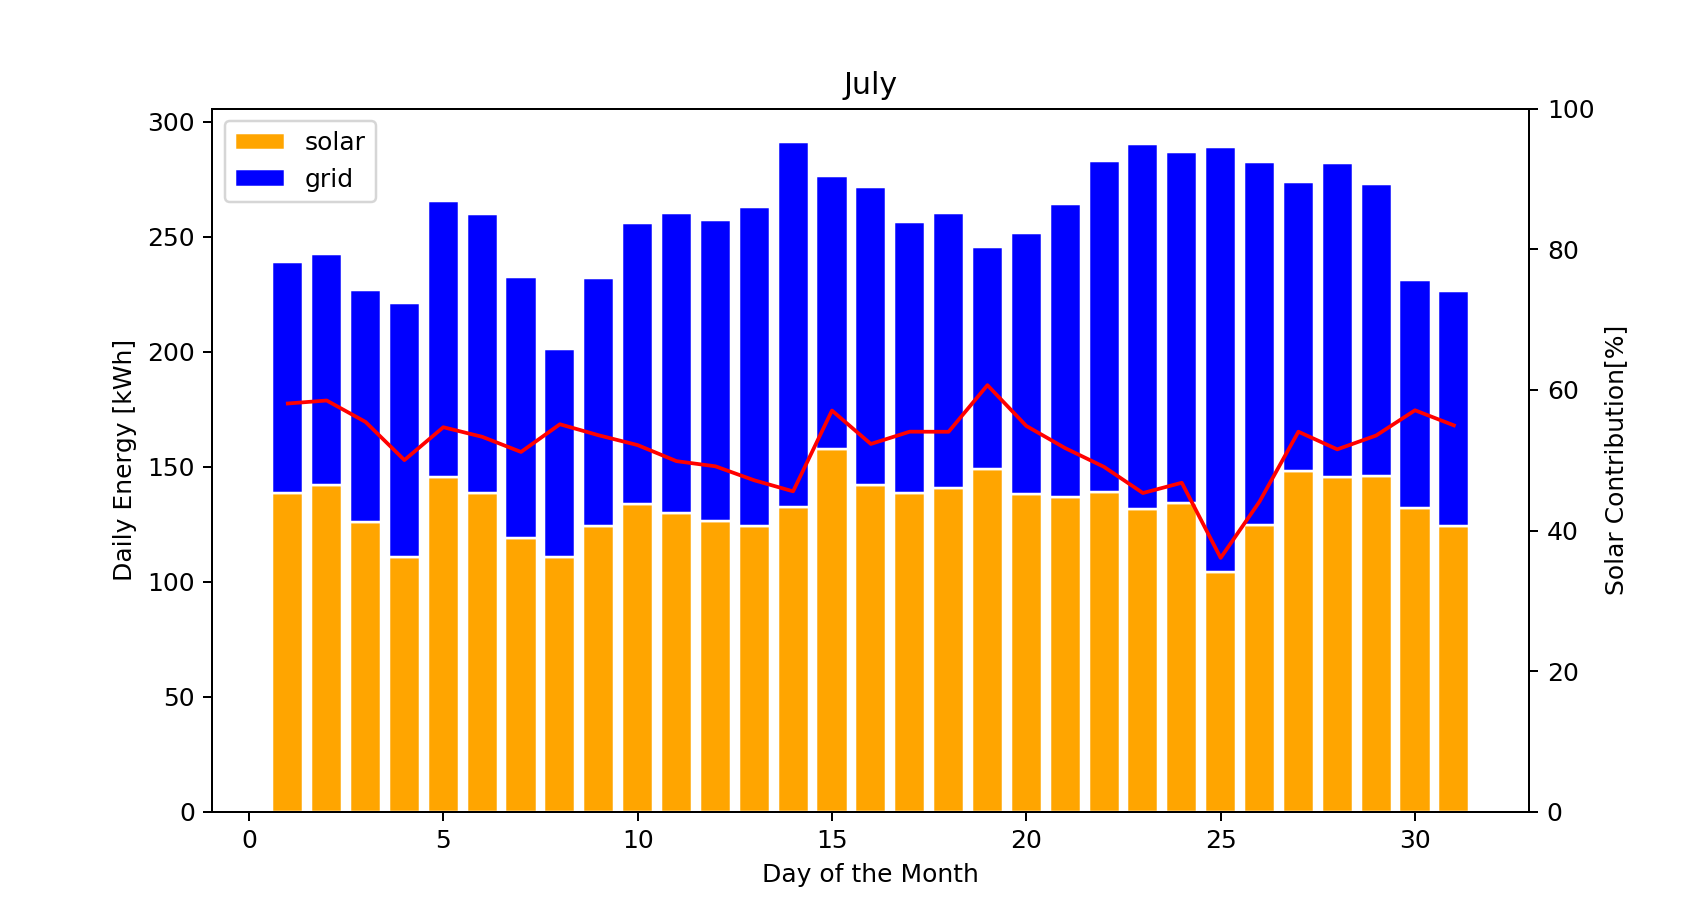

In [31]:
solar_contribution(july, 'July')


In [52]:
x_axis = range(1,31)
plt.bar(x_axis, daily_pv, color='orange',edgecolor='white', label='solar')
plt.bar(x_axis, daily_grid, bottom=daily_pv, color='blue', edgecolor='white', label='grid')
plt.xlabel('Day of the Month')
plt.ylabel('Daily Energy [kWh]')
plt.legend()
plt.title('July')

# Solar Contribution:
solar_cont = 100*(daily_pv/(daily_pv+daily_grid))

# x = np.linspace(0, N)
# y = np.sin(x)
axes2 = plt.twinx()
axes2.plot(x_axis, solar_cont, color='r')
axes2.set_ylim(0, 100)
axes2.set_ylabel('Solar Contribution[%]')

Text(0, 0.5, 'Solar Contribution[%]')

<IPython.core.display.Javascript object>


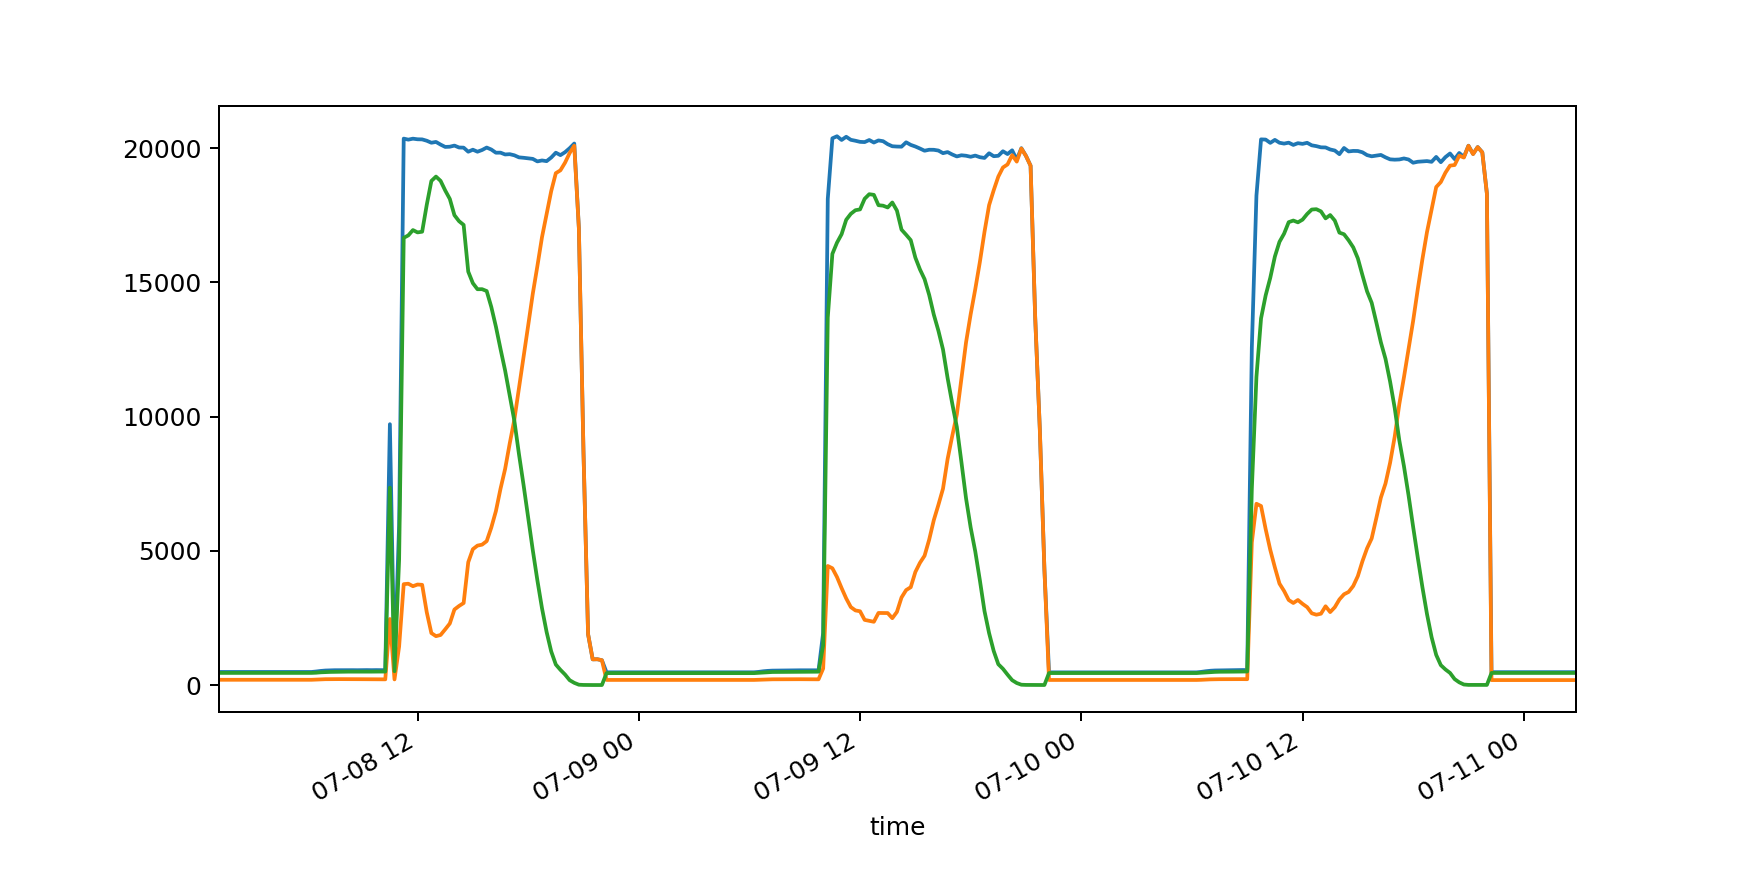

In [7]:
july = fan_aggregation(fan_list, 7)

In [8]:
july

,Total_Power,Grid_Power,PV_Power,day_of_week
time,,,,
2019-07-01 06:15:00-07:00,0.000000,0.000000,0.0,0
2019-07-01 06:30:00-07:00,0.000000,0.000000,0.0,0
2019-07-01 06:45:00-07:00,0.000000,0.000000,0.0,0
2019-07-01 07:00:00-07:00,0.000000,0.000000,0.0,0
2019-07-01 07:15:00-07:00,0.000000,0.000000,0.0,0
...,...,...,...,...
2019-07-31 20:00:00-07:00,19748.368500,19500.595000,0.0,2
2019-07-31 20:15:00-07:00,19863.048500,19759.608000,0.0,2
2019-07-31 20:30:00-07:00,19845.229500,19819.881500,0.0,2


In [3]:
df = pd.read_csv('DD_bill.csv')

FileNotFoundError: [Errno 2] File b'DD_bill.csv' does not exist: b'DD_bill.csv'